Name  : SILVA G.B.N.M. <br>
Index : 190592X

Q1

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import circle_fit as cf
import cv2 as cv

Q1

In [8]:
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0 , 2*np.pi , half_n )
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t),(r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))

m, b = -1, 2
x = np.linspace(-12, 12 , half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
X = np.vstack((X_circ,X_line))

In [40]:
def circle_ransac(data,error,s):
    threshold = np.std(data)/16
    required_iterations = np.log(1-(1-error))/np.log(1-(1-error)**s)
    max_inliers = 0
    model = None
    print(required_iterations,np.int64(np.ceil(required_iterations)))
    for iterations in range (np.int64(np.ceil(required_iterations))):
        np.random.shuffle(data)
        samples = data[:s]
        x_c,y_c,r,_ = cf.least_squares_circle((samples))
        err = np.abs(r - np.sqrt(np.sum(((x_c,y_c)-data[3:])**2,axis=1)))
        inliers = err <= threshold
        tot_inliers = np.count_nonzero(inliers)
        if tot_inliers >max_inliers :
            max_inliers = tot_inliers
            inlier_points = []
            for ind,inlr in enumerate(inliers):
                if inlr == True :
                    inlier_points.append(data[3:][ind])
            inlier_points = np.array(inlier_points)
            model = (samples,inlier_points)

    xc , yc , radius , _ = cf.least_squares_circle(np.concatenate((model[0],model[1]),axis = 0)) 
    return ((xc,yc),radius,model[0],model[1])  


1.5382162637106231 2


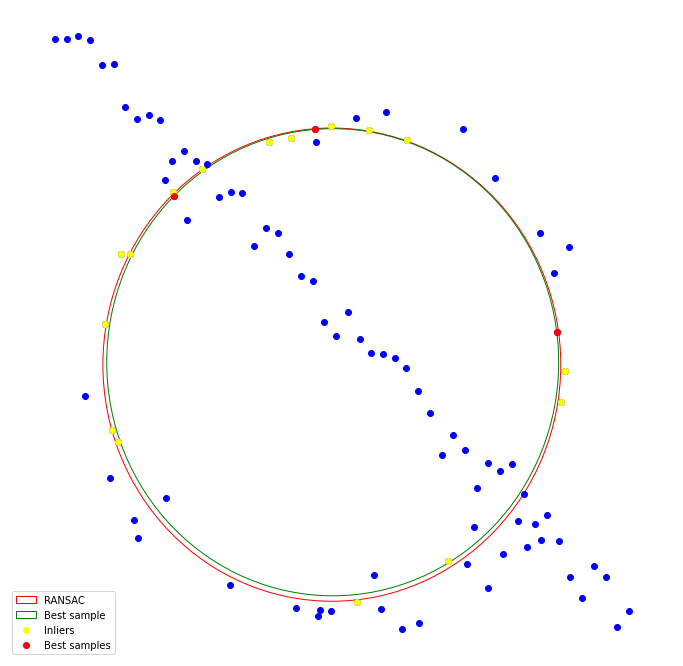

In [43]:
best_model = circle_ransac(X_circ,0.05,3)
xc,yc,r,_ = cf.least_squares_circle(best_model[2])

figure, ax = plt.subplots(figsize=(12, 12))
RASNSAC_circle = plt.Circle(best_model[0], best_model[1], fill=False, color='red', label='RANSAC')        
ax.add_artist(RASNSAC_circle)
circle = plt.Circle((xc, yc), r, fill=False, color='green', label='Best sample')    
ax.add_artist(circle)
ax.scatter(X_circ[:, 0], X_circ[:, 1], c='blue')
ax.scatter(X_line[:, 0], X_line[:, 1], c='blue')
ax.scatter(best_model[3][:, 0], best_model[3][:, 1], c='yellow', label='Inliers')
ax.scatter(best_model[2][:, 0], best_model[2][:, 1], c='red', label='Best samples')
plt.legend(loc=3)
plt.xlim(-14, 14)
plt.axis('off')
plt.savefig(r"images\1.png")
plt.show()

Q2

In [52]:
import cv2
img = cv2.imread('images/2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
background = cv2.imread('images/2.jpg')
background = cv2.cvtColor(background,cv2.COLOR_BGR2RGB)

rows,cols,ch = background.shape

pts1 = np.float32([[0,0],[974,0],[0,974],[974,974]]) # cola coords 
pts2 = np.float32([[560,383],[940, 516],[5,527],[298,733]]) # stadium tile coords

M = cv2.getPerspectiveTransform(pts1,pts2)    
dst = cv2.warpPerspective(img,M,(cols,rows))

overlay = cv2.add(background, dst)

cv2.namedWindow('Architectural Image')
#cv2.setMouseCallback('Architectural Image', CallBackFunc)
cv2.imshow("Architectural Image", overlay)
cv2.waitKey(0)

-1

Q3

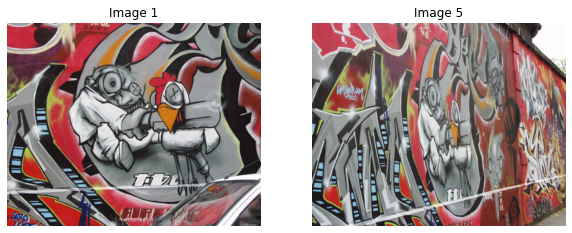

In [4]:
im1 = cv.imread(r'images/img1.ppm')
im2 = cv.imread(r'images/img5.ppm')

im1 = cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(im2,cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(im1)
ax[0].axis('off')
ax[0].set_title('Image 1')
ax[1].imshow(im2)
ax[1].axis('off')
ax[1].set_title('Image 5')
plt.show()

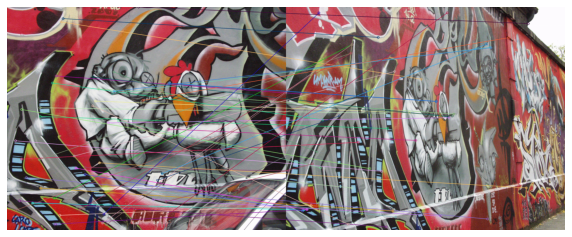

In [7]:
sift = cv.SIFT_create()

kp1, desc1 = sift.detectAndCompute(im1,None)
kp2, desc2 = sift.detectAndCompute(im2,None)

bf_match = cv.BFMatcher()
matches = bf_match.knnMatch(desc1,desc2,k=2)

best,pts1,pts2 = [] , [] , []

for pt1,pt2 in matches:
    if pt1.distance < 0.75 * pt2.distance:
        best.append([pt1])
        pts1.append(kp1[pt1.queryIdx].pt)
        pts2.append(kp2[pt2.trainIdx].pt)

best , pts1 , pts2 = np.array(best) , np.array(pts1) , np.array(pts2)

mtch_img = cv.drawMatchesKnn(im1,kp1,im2,kp2,best[:50],None,flags = 2)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(mtch_img)
ax.axis('off')
plt.savefig(r"images\q3a.jpg")
plt.show()

Homography without using RANSAC

In [8]:
def Homography(pts_1,pts_2):
    mean_1,mean_2 = np.mean(pts_1,axis=0) , np.mean(pts_2,axis=0)
    s_1 = len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts_1-mean_1)**2,axis = 1))) 
    s_2 = len(pts2)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts_2-mean_2)**2,axis = 1))) 

    tx_1 , ty_1 , tx_2, ty_2 = -s_1*mean_1[0], -s_1*mean_1[1] , -s_2*mean_2[0] , -s_2*mean_2[1]
    T_1 = np.array(((s_1,0,tx_1),(0,s_1,ty_1),(0,0,1)))
    T_2 = np.array(((s_2,0,tx_2),(0,s_2,ty_2),(0,0,1)))

    x_i = []

    for i in range (len(pts_1)):
        x_11 = T_1 @ np.concatenate((pts_1[i],[1])).reshape(3,1)
        x_21 = T_2 @ np.concatenate((pts_2[i],[1])).reshape(3,1)

        x_i.append((-x_11[0][0],-x_11[1][0],-1,0,0,0,x_21[0][0]*x_11[0][0],x_21[0][0]*x_11[0][0],x_21[0][0]))        
        x_i.append((0,0,0,-x_11[0][0],-x_11[1][0],-1,x_21[1][0]*x_11[1][0],x_21[1][0]))

    x_i = np.array(x_i)
    U , S , V = np.linalg.svd(x_i, full_matrices=True)
    h = np.reshape(V[-1],(3,3))
    H = linalg.inv(T_2) @ h @ T_1
    H = (1 / H.item(8)) * H
    return H
